<h1>PREDICTING WINE QUALITY</h1>

HERE I IMPLEMENT A MACHINE LEARNING PIPELINE ON A WINE QUALITY DATA SET. AN EXTRA AIM IS TO CREATE CODE THAT WILL WORK OTHER SIMILAR DATA SETS (PRECISE MODELS MAY NEED TO CHANGE): THIS WINE QUALITY DATA IS NICE, IN THE SENSE THAT ALL FEATURES ARE NUMERICAL AND THERE ARE NO MISSING VALUES.

<h2>IMPORT SOME LIBRARIES, READ IN DATA, PLOT FEATURE HISTOGRAMS</h2>

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4


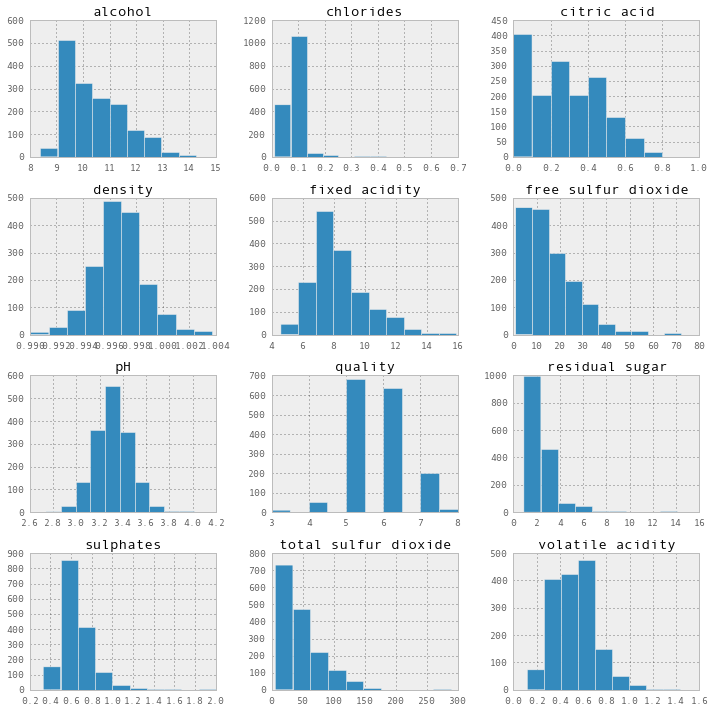

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
##check out tutorial here:
##http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/v0.1/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb
df = pd.read_csv('../winequality-red.csv' , sep = ';')
df1 = df.drop('quality' , 1) #drop target variable
pd.DataFrame.hist(df , figsize=[12,12]);
df1.head() 

NB: MULTIPLE FEATURES ARE NON-NORMALLY DISTRIBUTED -- IT WILL BE IMPORTANT TO DEAL WITH THIS (USING SOME OF TRANSFORM: LOGARITHMIC, BOX-COX OR YEO-JOHNSON)! BUT FIRST: LET'S VISUALIZE THE PRINCIPAL COMPONENTS TO GET A BIT MORE OF A FEEL FOR THE DATA.

<h2>LET'S HAVE A LOOK AT THE PRINCIPAL COMPONENTS</h2>

(1599, 2)


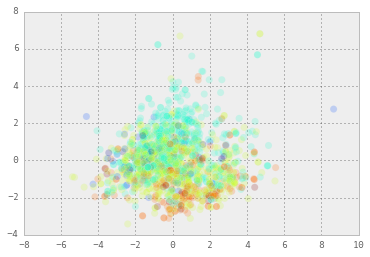

The amount of variance explained by the 1st & 2nd principal components are 0.282 & 0.175 respectively.


In [65]:
from sklearn.decomposition import PCA #import principal component analysis
pca = PCA(n_components=2) #Instantiate the model & set parameters
df2 = pd.DataFrame( scale(df1) )
pca.fit(df2); #Fit the model
df_pca = pca.transform(df2)#Apply the model. For embeddings / decompositions, this is transform.
print(df_pca.shape)
fig, ax = plt.subplots();
ax.scatter(df_pca[:, 0], df_pca[:, 1] , c = df['quality'] , s = 50 , alpha=0.2);
ax.legend(numpoints=1 , loc='upper left');
plt.show();
print("The amount of variance explained by the 1st & 2nd principal components are %s & %s respectively." 
      % (round(pca.explained_variance_ratio_[0],3) , round(pca.explained_variance_ratio_[1],3)))
#print("Thus the 1st 2 components explain >99% of the variance in the data: moreover, looking " +
     # "at the plot, there seems to be some distinction between target classes. All this is to say" +
     # " that there is hope for us still!")

[3 4 5 6 7 8]


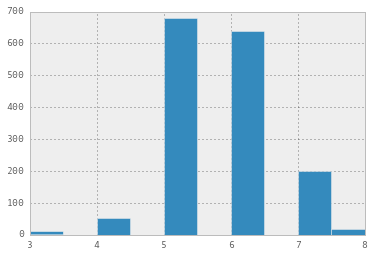

In [66]:
#WE'LL ALSO LOOK AT THE HISTOGRAM OF THE TARGET VARIABLE
target = df['quality'];
plt.hist(target);
print(np.unique(target))

NOTE: THERE IS A SERIOUS CLASS IMBALANCE. RATINGS '3' & '8' HAVE VERY FEW SAMPLES (THERE ARE 8 COUNTS IN THE '3' BIN, FOR EXAMPLE).

In [ ]:
#SOME NOTES FOR LATER ON BOOSTING ALGORITHMS:
#http://people.ee.duke.edu/~lcarin/ImbalancedClassDistribution.pdf
#'Boosting for Learning Multiple Classes with Imbalanced Class Distribution' and
#http://sci2s.ugr.es/sites/default/files/ficherosPublicaciones/1422_2011-Galar-IEEE_TSMCc-Ensembles.pdf
#'A Review on Ensembles for the Class Imbalance Problem: Bagging-, Boosting-, and Hybrid-Based Approaches'

#try this at some point: (multiclass adaboost)
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html

<h2>IT'S TIME TO DO SOME PREPROCESSING:</h2>

THERE'S A NICE CARET (R) VIGNETTE ON PREPROCESSING: WE'LL VAGUELY FOLLOW SOME OF IT HERE:
http://topepo.github.io/caret/preprocess.html

In [67]:
#FIRST: REMOVE ZERO VARIANCE AND NEAR-ZERO VARIANCE PREDICTOR
#THEY WILL CONFUSE MANY MODELS
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
X = selector.fit_transform(df1)
print( X.shape )

(1599, 11)


OK: THIS DID NOT REMOVE ANY FEATURES AT ALL BUT SETTING THE THRESHOLD = 0.05 REMOVED 2 AND SETTING IT = 0.1 REMOVED 6 -- FIGURE OUT PRECISELY WHAT THIS THRESHOLD IS.
ALSO NOTE: THERE IS MUCH ONLINE ARGUMENT ABOUT THE REMOVAL OF SUCH PREDICTORS --  A LOT OF PEOPLE SAY THAT MOST GOOD MODELS SHOULD REMOVE THEM THEMSELVES, FOR EXAMPLE.
    

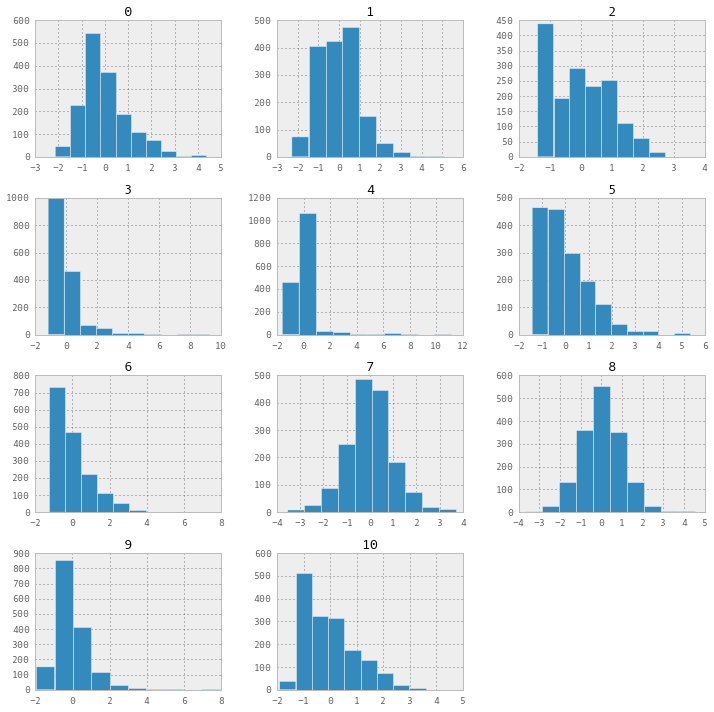

In [68]:
##SECOND: LET'S CENTRE AND SCALE ALL OF OUR FEATURES (WHY? SO THAT SOME DON'T 
##CONTRIBUTE TOO MUCH/LITTLE TO ANY ALGORITHM. FIND GOOD REF.)
from sklearn.preprocessing import scale
df2 = pd.DataFrame( scale(df1) ) #this centers AND scales
#axes = pd.tools.plotting.scatter_matrix(df1, alpha=0.2)
#plt.tight_layout()
#plt.show()
pd.DataFrame.hist(df2 , figsize=[12,12]); #plot histograms of centred/scaled features

<h2>TESTING FOR NORMALITY AND RELEVANT TRANSFORMS</h2>

THE IDEA HERE IS TO TEST FOR NORMALITY, TRANSFORM THE NON-NORMAL FEATURES AND THEN TEST FOR NORMALITY AGAIN TO MAKE SURE THAT WE DIDN'T MAKE THE DATA LESS GAUSSIAN!

In [69]:
##WE WANT THE FEATURES TO BE AS NORMAL/GAUSSIAN AS POSSIBLE (WHY? FIND A A GOOD REF. FOR THIS)
#LET'S TEST OUR FEATURES FOR NORMALITY 
from scipy.stats import shapiro
for i in range(0 , len(df2.columns) ):
    print shapiro(df2[i])[1]

1.5241635784e-24
2.68967371467e-16
1.02339447776e-21
0.0
0.0
7.69952279252e-31
3.57414360867e-34
1.92100770846e-08
1.72250884134e-06
5.82161767888e-38
6.643664825e-27


9.14958686593e-09
0.000597590988036
2.09677320195e-21
9.85319061716e-24
2.28999186105e-37
1.42208786413e-10
1.9607921331e-07
1.93992288899e-08
1.35670243253e-05
2.84718377347e-11
5.68849624387e-15


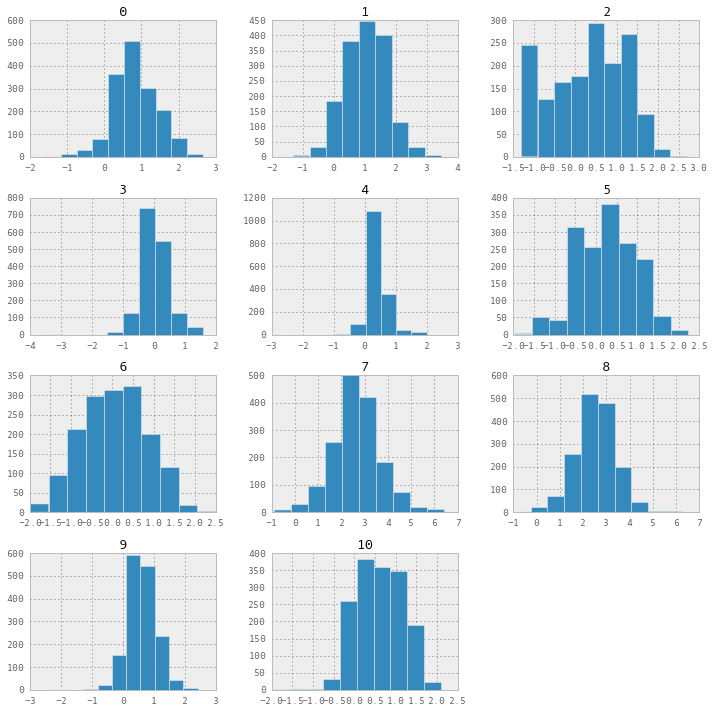

In [70]:
import box_cox as bc
df3 = bc.box_cox(df2) #transformed dataframe
pd.DataFrame.hist(df3 , figsize=[12,12]);
##WE WANT THE FEATURES TO BE AS NORMAL/GAUSSIAN AS POSSIBLE (WHY? FIND A A GOOD REF. FOR THIS)
#LET'S TEST OUR FEATURES FOR NORMALITY 
from scipy.stats import shapiro
for i in range(0 , len(df3.columns) ):
    print shapiro(df3[i])[1]

<h2>BEFORE MACHINE LEARNING, WE KEEP A HOLD-OUT SET TO TEST OUR MODELS ON THE VERY END:</h2>

In [71]:
#SPLIT DATA INTO TRAINING & TESTING HERE
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, df['quality'], test_size = 0.2, 
                                                    random_state=0)
print("X_train shape: %s" % repr(X_train.shape))
print("y_train shape: %s" % repr(y_train.shape))
print("X_test shape: %s" % repr(X_test.shape))
print("y_test shape: %s" % repr(y_test.shape))

X_train shape: (1279, 11)
y_train shape: (1279,)
X_test shape: (320, 11)
y_test shape: (320,)


<h2>NOW TO MACHINE LEARN! FIRST, LET'S TRY A LINEAR SVM WITH K-FOLD CROSS VALIDATION</h2>


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    6.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 0.10000000000000001}
0.570758405004


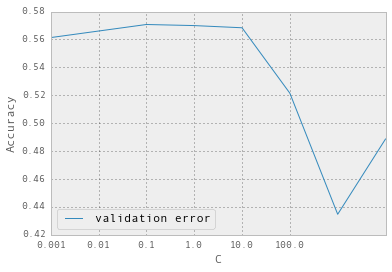

In [72]:
from sklearn.svm import LinearSVC
svm = LinearSVC() # Instantiate the model.
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
#also see here: http://scikit-learn.org/stable/auto_examples/grid_search_digits.html
svm = LinearSVC() # Instantiate the model
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search = GridSearchCV( svm , param_grid = tuned_parameters , cv = 5 ,verbose = 1 )
#number of folds must be < than the size of the least populated class
grid_search.fit(X_train, y_train);
print(grid_search.best_params_)
print(grid_search.best_score_)
##see here about the scoring:
##http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
##E.g. gives "accuracy" for SVMs:
##http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
plt.plot([c.mean_validation_score for c in grid_search.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');
#see this thread concerning mean_training_score:
#http://stackoverflow.com/questions/23389334/how-to-calculate-the-mean-training-score-using-gridsearchcv-in-scikit-learns

that's pretty poor performance! Note: I tried more folds but the algorithm complained because of the very small classes.

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.8s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 10.0}
0.608287724785


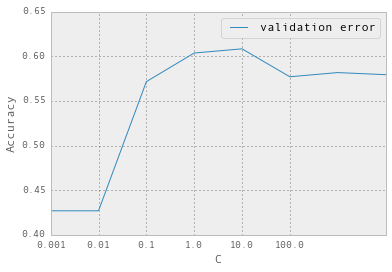

In [11]:
#SO LET'S TRY A GAUSSIAN SVM
from sklearn.svm import SVC
svm1 = SVC(kernel='rbf')# Instantiate the model (SVM w/ Gaussian kernel)
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search1 = GridSearchCV( svm1 , param_grid = tuned_parameters , cv = 5 ,verbose = 1 )
grid_search1.fit(X_train, y_train);
print(grid_search1.best_params_)
print(grid_search1.best_score_)
plt.plot([c.mean_validation_score for c in grid_search1.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');

this is a bit (2%/3%) better than the linear SVM.

<h3>IT'S TIME TO TRY A RANDOM FOREST</h3>

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.2s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'n_estimators': 70}
0.638937718881


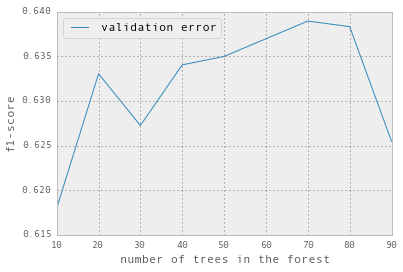

In [94]:
from sklearn.ensemble import RandomForestClassifier
#a random forest builds many randomized decision trees and averages their results.
rf = RandomForestClassifier() #Instantiate the model.
tuned_parameters = {'n_estimators':10*np.arange(1,10)}
grid_search2 = GridSearchCV( rf , param_grid = tuned_parameters , scoring= 'f1' ,
                            cv = 5 ,verbose = 1 )
grid_search2.fit(X_train, y_train);
print(grid_search2.best_params_)
print(grid_search2.best_score_)
plt.plot([c.mean_validation_score for c in grid_search2.grid_scores_], label="validation error");
plt.xticks(np.arange(9), tuned_parameters['n_estimators']); 
plt.xlabel("number of trees in the forest"); plt.ylabel("f1-score");plt.legend(loc='best');
##see here for scoring:
##http://scikit-learn.org/stable/modules/model_evaluation.html

ok, this also performs better than the previous two. But it does not seem robust! I.e., there different results each time that you run it. DISCUSS.

<h1>IT'S NOW TIME TO BUILD A PIPELINE</h1>
THIS PIPELINE WILL INCLUDE CENTERING AND SCALING SO WE GOT BACK TO OUR 
ORIGINAL DATAFRAME df ABOVE.

In [74]:
df = pd.read_csv('../winequality-red.csv' , sep = ';')
df1 = df.drop('quality' , 1) #drop target variable
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df['quality'], test_size = 0.2, 
                                                    random_state=0)
print("X_train shape: %s" % repr(X_train.shape))
print("y_train shape: %s" % repr(y_train.shape))
print("X_test shape: %s" % repr(X_test.shape))
print("y_test shape: %s" % repr(y_test.shape))

X_train shape: (1279, 11)
y_train shape: (1279,)
X_test shape: (320, 11)
y_test shape: (320,)


<h3>OPENING THE PIPELINE</h3>

In [75]:
#see here for intuition:
#http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
from sklearn import linear_model, decomposition, datasets, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
#build a scaler component to pipeline:
scaler = preprocessing.StandardScaler().fit(X_train)
#see here for 'scaler in pipeline' details: 
#http://scikit-learn.org/stable/modules/preprocessing.html
svm = LinearSVC() # Instantiate the model
tuned_parameters = 10.**np.arange(-3,5)
#this is the pipe!:
pipe = Pipeline(steps=[('scale', scaler), ('svm', svm)])

In [76]:
estimator = GridSearchCV(pipe,
                         dict(
                              svm__C=tuned_parameters))
estimator.fit(X_train , y_train);
print(estimator.best_estimator_)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0))])


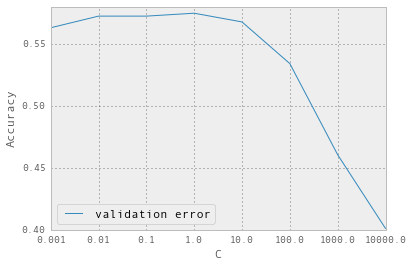

In [77]:
plt.plot([c.mean_validation_score for c in estimator.grid_scores_], label="validation error")
plt.xticks(np.arange(len(tuned_parameters)), tuned_parameters); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');

<h2>NOW LET'S GO FOR A LOGISITIC REGRESSION PIPELINE</h2>

In [79]:
#see here for intuition:
#http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
from sklearn import linear_model, decomposition, datasets, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
#build a scaler component to pipeline:
#scaler = preprocessing.StandardScaler().fit(X_train)
#see here for 'scaler in pipeline' details: 
#http://scikit-learn.org/stable/modules/preprocessing.html
#X_train_scaled = scaler.transform(X_train)
#Instantiate a model:
logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [80]:
# Prediction

n_components = [2,4,6,8,11]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))

estimator.fit(X_train , y_train);
print(estimator.best_estimator_)
estimator.grid_scores_

Pipeline(steps=[('pca', PCA(copy=True, n_components=11, whiten=False)), ('logistic', LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=None, tol=0.0001))])


[mean: 0.48319, std: 0.01688, params: {'logistic__C': 0.0001, 'pca__n_components': 2},
 mean: 0.48241, std: 0.02417, params: {'logistic__C': 0.0001, 'pca__n_components': 4},
 mean: 0.48397, std: 0.02298, params: {'logistic__C': 0.0001, 'pca__n_components': 6},
 mean: 0.48397, std: 0.02298, params: {'logistic__C': 0.0001, 'pca__n_components': 8},
 mean: 0.48397, std: 0.02298, params: {'logistic__C': 0.0001, 'pca__n_components': 11},
 mean: 0.48944, std: 0.01743, params: {'logistic__C': 1.0, 'pca__n_components': 2},
 mean: 0.48632, std: 0.01183, params: {'logistic__C': 1.0, 'pca__n_components': 4},
 mean: 0.56919, std: 0.00912, params: {'logistic__C': 1.0, 'pca__n_components': 6},
 mean: 0.57154, std: 0.00916, params: {'logistic__C': 1.0, 'pca__n_components': 8},
 mean: 0.57310, std: 0.00814, params: {'logistic__C': 1.0, 'pca__n_components': 11},
 mean: 0.48944, std: 0.01583, params: {'logistic__C': 10000.0, 'pca__n_components': 2},
 mean: 0.48632, std: 0.01183, params: {'logistic__C': 1

NOTES: HOW DO YOU PIPE TOGETHER M A VARIETY OF MODELS? SOME SORT OF ENSEMBLE METHODS FUNCTION? ALSO, I COULDN'T PIPE THE SCALER TO THE LOGISTIC REGRESSION FOR SOME REASON, DEBUG THIS, PLEASE.
JUST CHATTED WITH FERNANDO:
WHAT METRIC OF MODEL PERFORMANCE DO WE WANT? HE USES F1, I USE ACCURACY CURRENTLY BUT REALLY WE WANT TO PENALIZE RATINGS THAT ARE FURTHER AWAY SO WE NEED TO USE REGRESSION OR SOME SORT OF ORDINAL CLASSIFIER, RIGHT?
OTHER QUESTIONS: 
DOES NORMALIZING/TRANSFORMING ACTUALLY DATA IMPROVE PERFORMANCE?
DO WE WANT TO USE STRATIFIED K-FOLD CROSS VALIDATION?